In [34]:
# setup: install/download once (you can comment out after first run)
# !pip install nltk textblob
import nltk
nltk.download('vader_lexicon')
from textblob import TextBlob

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ruhin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [35]:
# valence: VADER compound score in [-1, 1]
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

# load dataset
df_flat = pd.read_csv('data/beyondblue_data_flattened.csv')

sia = SentimentIntensityAnalyzer()

df_flat['valence_vader'] = df_flat['text'].astype(str).apply(
    lambda x: sia.polarity_scores(x)['compound']
)

df_flat[['text', 'valence_vader']].head(10)

,text,valence_vader
0,"Hello everyone, this is my first post, so I ho...",0.9631
1,"Hi Toby, welcome and congratulations on your f...",0.9143
2,"Hi Toby, Reading your post sounds just like wh...",-0.1589
3,"Hello Toby,I'm glad you've decided to reach ou...",0.8360
4,My anxiety is affecting my whole life. When I ...,0.9514
5,Hi my name is Michelle and I have had Anxiety ...,-0.1039
6,Dear Michelle ~Welcome here to the Support For...,0.9342
7,"Hey Michelle, thanks for sharing, that sounds ...",0.9259
8,sorry if this is alot i just rlly need to get ...,-0.9558
9,Hello I'm so sorry that you feel like this. An...,0.9907


In [36]:
# arousal proxy 1: TextBlob subjectivity in [0, 1]
# higher subjectivity ≈ more personally expressive language (a rough arousal proxy)
df_flat['subjectivity_tb'] = df_flat['text'].astype(str).apply(
    lambda x: TextBlob(x).sentiment.subjectivity
)

df_flat[['text', 'subjectivity_tb']].head(10)

,text,subjectivity_tb
0,"Hello everyone, this is my first post, so I ho...",0.542708
1,"Hi Toby, welcome and congratulations on your f...",0.411905
2,"Hi Toby, Reading your post sounds just like wh...",0.463262
3,"Hello Toby,I'm glad you've decided to reach ou...",0.625000
4,My anxiety is affecting my whole life. When I ...,0.531313
5,Hi my name is Michelle and I have had Anxiety ...,0.393415
6,Dear Michelle ~Welcome here to the Support For...,0.489680
7,"Hey Michelle, thanks for sharing, that sounds ...",0.491071
8,sorry if this is alot i just rlly need to get ...,0.420660
9,Hello I'm so sorry that you feel like this. An...,0.530008


In [37]:
# arousal proxy 2: simple intensity cues (punctuation, ALL CAPS, elongated words)
import re
import numpy as np

def intensity_score(s: str) -> float:
    s = str(s)
    exclam = s.count('!')
    ques   = s.count('?')
    caps   = sum(1 for w in re.findall(r'\b[A-Z]{2,}\b', s))  # ALL CAPS tokens
    elong  = len(re.findall(r'([a-zA-Z])\1{2,}', s))          # loooong / sooooo
    # weighted sum (tune weights later if needed)
    score = 0.6*exclam + 0.6*ques + 0.3*caps + 0.4*elong
    return score

raw_intensity = df_flat['text'].apply(intensity_score)

# min-max scale to [0,1] for interpretability
if raw_intensity.max() > 0:
    df_flat['intensity_scaled'] = (raw_intensity - raw_intensity.min()) / (raw_intensity.max() - raw_intensity.min())
else:
    df_flat['intensity_scaled'] = 0.0

df_flat[['text','intensity_scaled']].head(10)

,text,intensity_scaled
0,"Hello everyone, this is my first post, so I ho...",0.00000
1,"Hi Toby, welcome and congratulations on your f...",0.00000
2,"Hi Toby, Reading your post sounds just like wh...",0.00000
3,"Hello Toby,I'm glad you've decided to reach ou...",0.00000
4,My anxiety is affecting my whole life. When I ...,0.00625
5,Hi my name is Michelle and I have had Anxiety ...,0.00000
6,Dear Michelle ~Welcome here to the Support For...,0.01250
7,"Hey Michelle, thanks for sharing, that sounds ...",0.00000
8,sorry if this is alot i just rlly need to get ...,0.00000
9,Hello I'm so sorry that you feel like this. An...,0.00625


In [38]:
# combine arousal proxies into a single arousal score in [0,1]
# simple average of TextBlob subjectivity and intensity cue score
df_flat['arousal_simple'] = (df_flat['subjectivity_tb'] + df_flat['intensity_scaled']) / 2.0

df_flat[['text','valence_vader','arousal_simple']].head(10)

,text,valence_vader,arousal_simple
0,"Hello everyone, this is my first post, so I ho...",0.9631,0.271354
1,"Hi Toby, welcome and congratulations on your f...",0.9143,0.205952
2,"Hi Toby, Reading your post sounds just like wh...",-0.1589,0.231631
3,"Hello Toby,I'm glad you've decided to reach ou...",0.8360,0.312500
4,My anxiety is affecting my whole life. When I ...,0.9514,0.268782
5,Hi my name is Michelle and I have had Anxiety ...,-0.1039,0.196707
6,Dear Michelle ~Welcome here to the Support For...,0.9342,0.251090
7,"Hey Michelle, thanks for sharing, that sounds ...",0.9259,0.245536
8,sorry if this is alot i just rlly need to get ...,-0.9558,0.210330
9,Hello I'm so sorry that you feel like this. An...,0.9907,0.268129


In [39]:
# optional sanity checks: quick summary
print("Valence (VADER) summary:\n", df_flat['valence_vader'].describe(), "\n")
print("Arousal (combined) summary:\n", df_flat['arousal_simple'].describe())

Valence (VADER) summary:
 count    42961.000000
mean         0.365399
std          0.753214
min         -0.999700
25%         -0.366300
50%          0.812600
75%          0.969800
max          0.999800
Name: valence_vader, dtype: float64 

Arousal (combined) summary:
 count    42961.000000
mean         0.259984
std          0.071919
min          0.000000
25%          0.227778
50%          0.263739
75%          0.298998
max          0.833426
Name: arousal_simple, dtype: float64


In [40]:
# optional: save enriched features for downstream use
df_flat.to_csv("data/beyondblue_flat_valence_arousal.csv", index=False)
print("saved -> data/beyondblue_flat_valence_arousal.csv")

saved -> data/beyondblue_flat_valence_arousal.csv


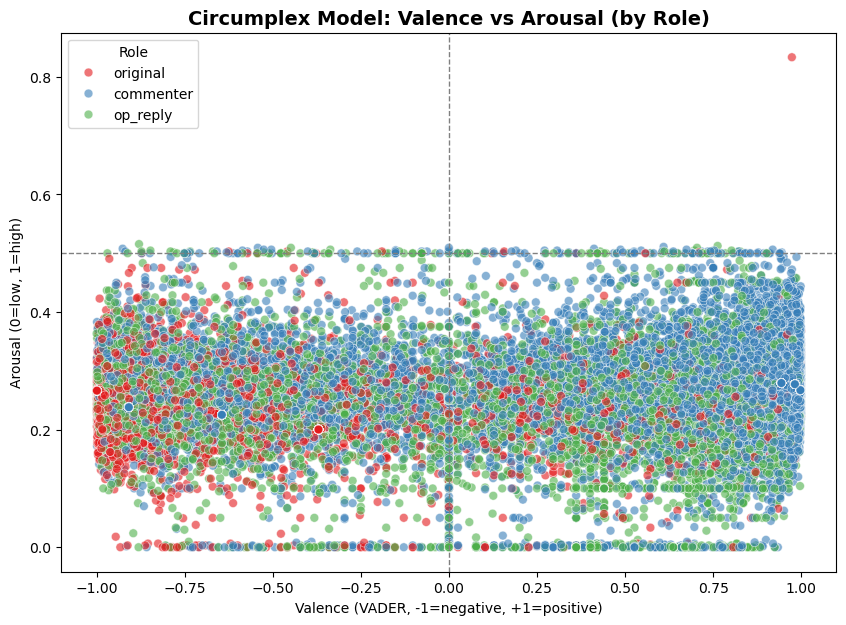

In [41]:
# Circumplex Scatter Plot (Valence vs Arousal by Role)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_flat,
    x='valence_vader',
    y='arousal_simple',
    hue='role',
    alpha=0.6,
    s=40,
    palette="Set1"
)

# axis styling
plt.axvline(0, color='grey', linestyle='--', lw=1)
plt.axhline(0.5, color='grey', linestyle='--', lw=1)
plt.xlabel("Valence (VADER, -1=negative, +1=positive)")
plt.ylabel("Arousal (0=low, 1=high)")
plt.title("Circumplex Model: Valence vs Arousal (by Role)", fontsize=14, weight='bold')
plt.legend(title="Role")
plt.show()

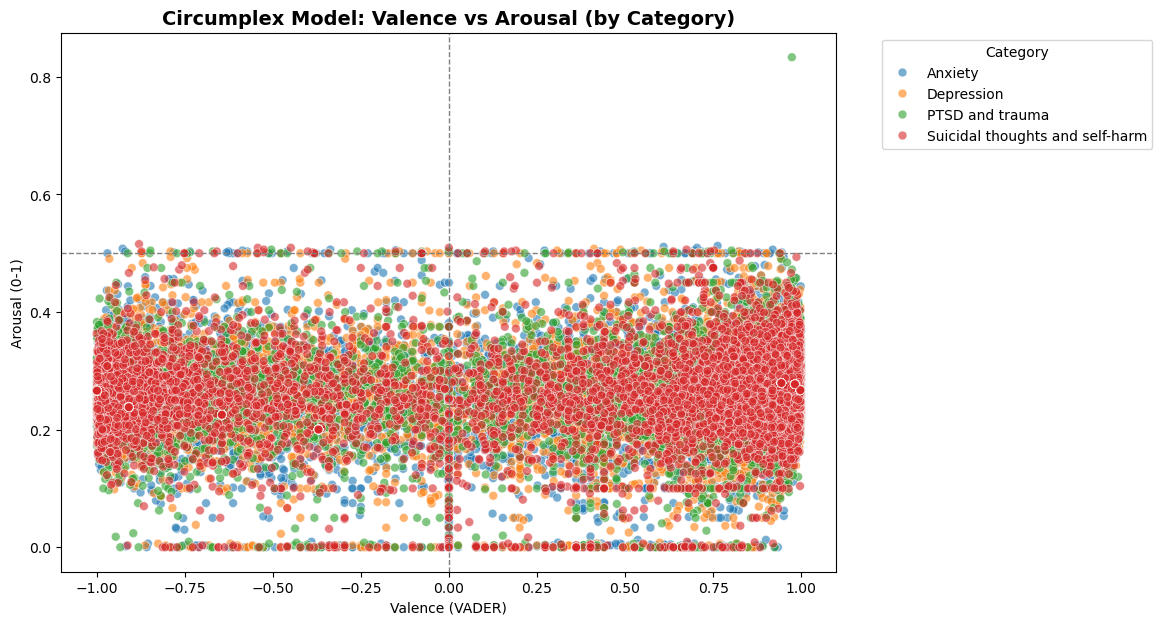

In [42]:
# 🎯 Circumplex Scatter Plot (Valence vs Arousal by Category)
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_flat,
    x='valence_vader',
    y='arousal_simple',
    hue='category',
    alpha=0.6,
    s=40,
    palette="tab10"
)

plt.axvline(0, color='grey', linestyle='--', lw=1)
plt.axhline(0.5, color='grey', linestyle='--', lw=1)
plt.xlabel("Valence (VADER)")
plt.ylabel("Arousal (0-1)")
plt.title("Circumplex Model: Valence vs Arousal (by Category)", fontsize=14, weight='bold')
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

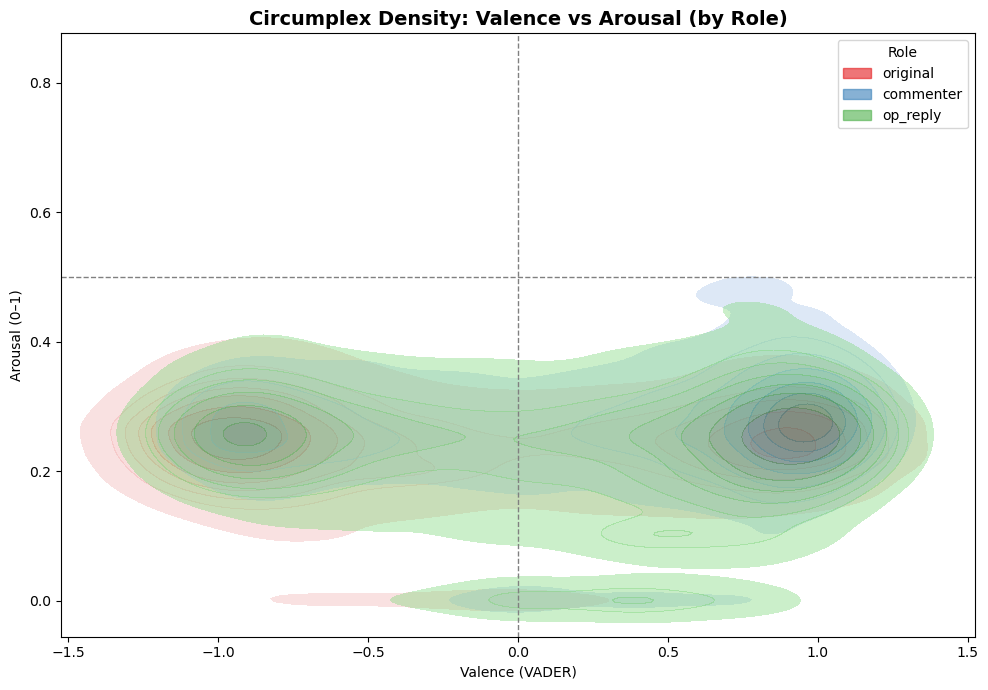

In [43]:
# Circumplex Density by Role (robust legend via proxy patches)
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

plot_df = df_flat[['valence_vader','arousal_simple','role']].dropna()

plt.figure(figsize=(10,7))

roles = plot_df['role'].unique()
colors = sns.color_palette("Set1", len(roles))
legend_patches = []

for role, color in zip(roles, colors):
    sub = plot_df[plot_df['role'] == role]
    if sub.empty:
        continue
    sns.kdeplot(
        data=sub,
        x='valence_vader',
        y='arousal_simple',
        fill=True,
        alpha=0.4,
        thresh=0.05,
        levels=8,
        color=color
    )
    legend_patches.append(Patch(facecolor=color, edgecolor=color, alpha=0.6, label=role))

plt.axvline(0, color='grey', linestyle='--', lw=1)
plt.axhline(0.5, color='grey', linestyle='--', lw=1)
plt.xlabel("Valence (VADER)")
plt.ylabel("Arousal (0–1)")
plt.title("Circumplex Density: Valence vs Arousal (by Role)", fontsize=14, weight='bold')
plt.legend(handles=legend_patches, title="Role")
plt.tight_layout()
plt.show()

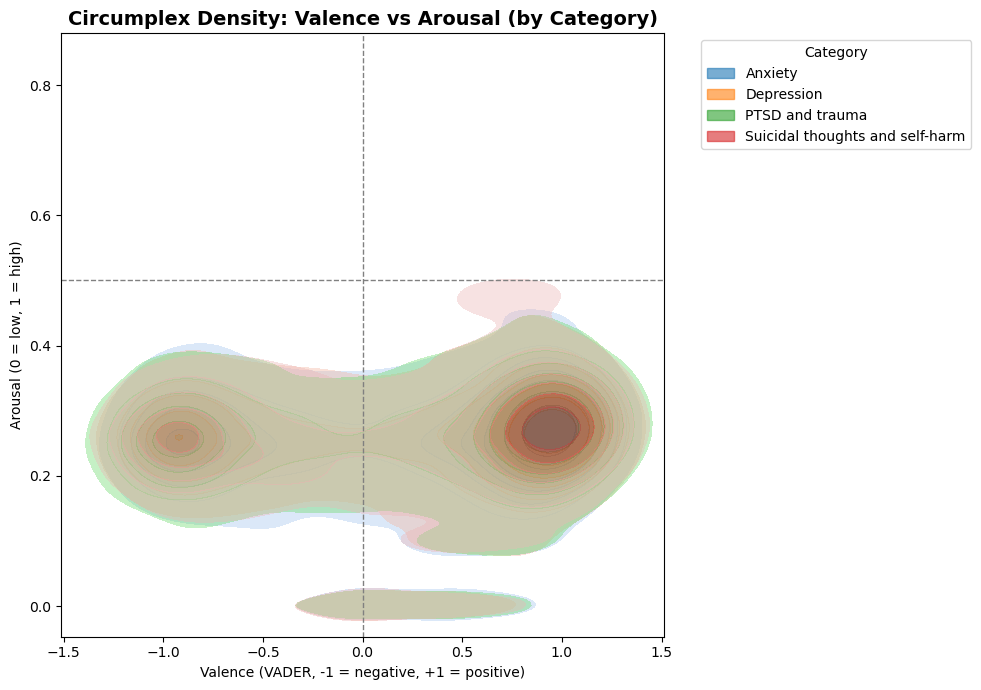

In [44]:
# Circumplex Density by Category (robust legend via proxy patches)
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# clean subset (drop NaNs)
plot_df = df_flat[['valence_vader','arousal_simple','category']].dropna()

plt.figure(figsize=(10,7))

cats = plot_df['category'].unique()
colors = sns.color_palette("tab10", len(cats))
legend_patches = []

for cat, color in zip(cats, colors):
    sub = plot_df[plot_df['category'] == cat]
    if sub.empty:
        continue
    sns.kdeplot(
        data=sub,
        x='valence_vader',
        y='arousal_simple',
        fill=True,
        alpha=0.4,
        thresh=0.05,
        levels=8,
        color=color
    )
    # add a proxy artist for the legend
    legend_patches.append(Patch(facecolor=color, edgecolor=color, alpha=0.6, label=cat))

plt.axvline(0, color='grey', linestyle='--', lw=1)
plt.axhline(0.5, color='grey', linestyle='--', lw=1)
plt.xlabel("Valence (VADER, -1 = negative, +1 = positive)")
plt.ylabel("Arousal (0 = low, 1 = high)")
plt.title("Circumplex Density: Valence vs Arousal (by Category)", fontsize=14, weight='bold')

# force legend using proxy patches
plt.legend(handles=legend_patches, title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()